In [18]:
import keras
import distutils
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os

Data Engineering ..

In [19]:
# Loading data
data = pd.read_csv('C:\\Users\\JawadLaptop\\~\\openaq-data\\csv.gz\\csv saudi\\merged_data.csv',
                   names=['location_id', 'sensors_id', 'location', 'datetime', 'lat', 'lon', 'parameter', 'units', 'value', 'year', 'month', 'measurand'],
                   low_memory=False,
                   skiprows=1,
                  )

data = data.drop(columns=['measurand', 'sensors_id', 'location', 'units', 'year', 'month'])
data = data.drop_duplicates(keep='first')
data = data[data['value'] != 0]
data = data.dropna(subset=['parameter'])
data

,location_id,datetime,lat,lon,parameter,value
0,233401,2021-08-25T12:00:00-01:00,24.681220,46.62074,pm25,36.00
1,233401,2021-08-25T16:00:00-01:00,24.681220,46.62074,pm25,41.00
2,65623,2023-02-07T00:04:46-01:00,22.316000,39.09200,pm10,7.80
3,65623,2023-02-07T00:06:46-01:00,22.316000,39.09200,pm10,8.20
4,65623,2023-02-07T00:08:46-01:00,22.316000,39.09200,pm10,8.30
...,...,...,...,...,...,...
1257671,370092,2022-11-10T23:35:47-01:00,24.702744,46.71336,um100,0.01
1257673,370092,2022-11-10T23:39:47-01:00,24.702744,46.71336,um100,0.01
1257676,370092,2022-11-10T23:45:47-01:00,24.702744,46.71336,um100,0.01
1257677,370092,2022-11-10T23:49:47-01:00,24.702744,46.71336,um100,0.01


In [20]:
data['datetime'] = pd.to_datetime(data['datetime'], utc=True)

data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day

data.set_index('datetime', inplace=True)
data = data.sort_index()
data

,location_id,lat,lon,parameter,value,hour,year,month,day
datetime,,,,,,,,,
2019-07-15 19:00:00+00:00,6993,26.304855,50.154302,pm25,34.0,19,2019,7,15
2019-07-15 20:00:00+00:00,6993,26.304855,50.154302,pm25,35.0,20,2019,7,15
2019-07-15 21:00:00+00:00,6993,26.304855,50.154302,pm25,35.0,21,2019,7,15
2019-07-15 22:00:00+00:00,6993,26.304855,50.154302,pm25,32.0,22,2019,7,15
2019-07-15 23:00:00+00:00,6993,26.304855,50.154302,pm25,22.0,23,2019,7,15
...,...,...,...,...,...,...,...,...,...
2023-04-15 17:00:00+00:00,7673,21.543486,39.172989,pm25,21.0,17,2023,4,15
2023-04-15 18:00:00+00:00,7673,21.543486,39.172989,pm25,23.0,18,2023,4,15
2023-04-15 19:00:00+00:00,7673,21.543486,39.172989,pm25,24.0,19,2023,4,15


In [21]:
def calculate_aqi(parameter, value):
    if parameter in ['pm10', 'pm25', 'pm1', 'um010', 'um025', 'um100']:
        if 0 <= value <= 12.0:
            return ((50 - 0) / (12.0 - 0)) * (value - 0) + 0
        elif 12.1 <= value <= 35.4:
            return ((100 - 51) / (35.4 - 12.1)) * (value - 12.1) + 51
        elif 35.5 <= value <= 55.4:
            return ((150 - 101) / (55.4 - 35.5)) * (value - 35.5) + 101
        elif 55.5 <= value <= 150.4:
            return ((200 - 151) / (150.4 - 55.5)) * (value - 55.5) + 151
        elif 150.5 <= value <= 250.4:
            return ((300 - 201) / (250.4 - 150.5)) * (value - 150.5) + 201
        elif 250.5 <= value <= 350.4:
            return ((400 - 301) / (350.4 - 250.5)) * (value - 250.5) + 301
        elif 350.5 <= value <= 500.4:
            return ((500 - 401) / (500.4 - 350.5)) * (value - 350.5) + 401
    elif parameter == 'o3':
        if 0.000 <= value <= 0.054:
            return ((50 - 0) / (0.054 - 0.000)) * (value - 0.000) + 0
        elif 0.055 <= value <= 0.070:
            return ((100 - 51) / (0.070 - 0.055)) * (value - 0.055) + 51
        elif 0.071 <= value <= 0.085:
            return ((150 - 101) / (0.085 - 0.071)) * (value - 0.071) + 101
        elif 0.086 <= value <= 0.105:
            return ((200 - 151) / (0.105 - 0.086)) * (value - 0.086) + 151
        elif 0.106 <= value <= 0.200:
            return ((300 - 201) / (0.200 - 0.106)) * (value - 0.106) + 201
        elif 0.201 <= value <= 0.405:
            return ((400 - 301) / (0.405 - 0.201)) * (value - 0.201) + 301
        elif 0.406 <= value <= 0.505:
            return ((500 - 401) / (0.505 - 0.406)) * (value - 0.406) + 401
    else:
        return None

data['AQI'] = data.apply(lambda row: calculate_aqi(row['parameter'], row['value']), axis=1)
data = data.drop(columns=['parameter', 'value'])
data = data.dropna()
data

,location_id,lat,lon,hour,year,month,day,AQI
datetime,,,,,,,,
2019-07-15 19:00:00+00:00,6993,26.304855,50.154302,19,2019,7,15,97.055794
2019-07-15 20:00:00+00:00,6993,26.304855,50.154302,20,2019,7,15,99.158798
2019-07-15 21:00:00+00:00,6993,26.304855,50.154302,21,2019,7,15,99.158798
2019-07-15 22:00:00+00:00,6993,26.304855,50.154302,22,2019,7,15,92.849785
2019-07-15 23:00:00+00:00,6993,26.304855,50.154302,23,2019,7,15,71.819742
...,...,...,...,...,...,...,...,...
2023-04-15 17:00:00+00:00,7673,21.543486,39.172989,17,2023,4,15,69.716738
2023-04-15 18:00:00+00:00,7673,21.543486,39.172989,18,2023,4,15,73.922747
2023-04-15 19:00:00+00:00,7673,21.543486,39.172989,19,2023,4,15,76.025751


In [22]:
data['Seconds'] = data.index.map(pd.Timestamp.timestamp)

day = 60*60*24
year = 365.2425*day

data['Day sin'] = np.sin(data['Seconds'] * (2* np.pi / day))
data['Day cos'] = np.cos(data['Seconds'] * (2 * np.pi / day))
data['Year sin'] = np.sin(data['Seconds'] * (2 * np.pi / year))
data['Year cos'] = np.cos(data['Seconds'] * (2 * np.pi / year))

data = data.drop(columns=['Seconds'])
data

,location_id,lat,lon,hour,year,month,day,AQI,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,,,,,,,
2019-07-15 19:00:00+00:00,6993,26.304855,50.154302,19,2019,7,15,97.055794,-0.965926,2.588190e-01,-0.226604,-0.973987
2019-07-15 20:00:00+00:00,6993,26.304855,50.154302,20,2019,7,15,99.158798,-0.866025,5.000000e-01,-0.227302,-0.973824
2019-07-15 21:00:00+00:00,6993,26.304855,50.154302,21,2019,7,15,99.158798,-0.707107,7.071068e-01,-0.228000,-0.973661
2019-07-15 22:00:00+00:00,6993,26.304855,50.154302,22,2019,7,15,92.849785,-0.500000,8.660254e-01,-0.228697,-0.973498
2019-07-15 23:00:00+00:00,6993,26.304855,50.154302,23,2019,7,15,71.819742,-0.258819,9.659258e-01,-0.229395,-0.973333
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-15 17:00:00+00:00,7673,21.543486,39.172989,17,2023,4,15,69.716738,-0.965926,-2.588190e-01,0.972975,-0.230912
2023-04-15 18:00:00+00:00,7673,21.543486,39.172989,18,2023,4,15,73.922747,-1.000000,-8.492019e-12,0.972809,-0.231610
2023-04-15 19:00:00+00:00,7673,21.543486,39.172989,19,2023,4,15,76.025751,-0.965926,2.588190e-01,0.972643,-0.232307


In [23]:
# Creating a unique identifier for aggregation
data['unique_key'] = data.apply(lambda row: f"{row['location_id']}_{row['lat']}_{row['lon']}_{row['hour']}_{row['year']}_{row['month']}_{row['day']}", axis=1)

# Initializing data structures for aggregation
result_dict = {}
for index, row in data.iterrows():
    key = row['unique_key']
    if key not in result_dict:
        result_dict[key] = {
            'mean_aqi': row['AQI'],
            'count': 1,
            'Day sin': [row['Day sin']],
            'Day cos': [row['Day cos']],
            'Year sin': [row['Year sin']],
            'Year cos': [row['Year cos']]
        }
    else:
        result_dict[key]['mean_aqi'] += row['AQI']
        result_dict[key]['count'] += 1
        result_dict[key]['Day sin'].append(row['Day sin'])
        result_dict[key]['Day cos'].append(row['Day cos'])
        result_dict[key]['Year sin'].append(row['Year sin'])
        result_dict[key]['Year cos'].append(row['Year cos'])

# Calculating mean values for trigonometric features and mean AQI
final_data = []
for key, values in result_dict.items():
    location_id, lat, lon, hour, year, month, day = key.split('_')
    final_data.append({
        'location_id': location_id,
        'lat': lat,
        'lon': lon,
        'hour': hour,
        'year': year,
        'month': month,
        'day': day,
        'mean_aqi': values['mean_aqi'] / values['count'],
        'Day sin': np.mean(values['Day sin']),
        'Day cos': np.mean(values['Day cos']),
        'Year sin': np.mean(values['Year sin']),
        'Year cos': np.mean(values['Year cos'])
    })

result_df = pd.DataFrame(final_data)
result_df = result_df.drop(columns=['hour', 'year', 'month', 'day'])

# Convert location Id to columns and then to 0 and 1
result_df = pd.get_dummies(result_df, columns=['location_id'], prefix='loc')
for column in result_df.columns:
    if result_df[column].dtype == 'bool':
        result_df[column] = result_df[column].astype(int)

result_df

,lat,lon,mean_aqi,Day sin,Day cos,Year sin,Year cos,loc_233401.0,loc_370092.0,loc_65623.0,loc_69675.0,loc_6993.0,loc_7673.0,loc_8688.0
0,26.304855,50.154302,97.055794,-0.965926,2.588190e-01,-0.226604,-0.973987,0,0,0,0,1,0,0
1,26.304855,50.154302,99.158798,-0.866025,5.000000e-01,-0.227302,-0.973824,0,0,0,0,1,0,0
2,26.304855,50.154302,99.158798,-0.707107,7.071068e-01,-0.228000,-0.973661,0,0,0,0,1,0,0
3,26.304855,50.154302,92.849785,-0.500000,8.660254e-01,-0.228697,-0.973498,0,0,0,0,1,0,0
4,26.304855,50.154302,71.819742,-0.258819,9.659258e-01,-0.229395,-0.973333,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23296,21.543486,39.172989,69.716738,-0.965926,-2.588190e-01,0.972975,-0.230912,0,0,0,0,0,1,0
23297,21.543486,39.172989,73.922747,-1.000000,-8.492019e-12,0.972809,-0.231610,0,0,0,0,0,1,0
23298,21.543486,39.172989,76.025751,-0.965926,2.588190e-01,0.972643,-0.232307,0,0,0,0,0,1,0
23299,21.543486,39.172989,78.128755,-0.866025,5.000000e-01,0.972476,-0.233004,0,0,0,0,0,1,0


In [24]:
scaler_lat = StandardScaler()
scaler_lon = StandardScaler()
scaler_aqi = StandardScaler()

result_df[['lat']] = scaler_lat.fit_transform(result_df[['lat']])
result_df[['lon']] = scaler_lon.fit_transform(result_df[['lon']])
result_df[['mean_aqi']] = scaler_aqi.fit_transform(result_df[['mean_aqi']])

result_df

,lat,lon,mean_aqi,Day sin,Day cos,Year sin,Year cos,loc_233401.0,loc_370092.0,loc_65623.0,loc_69675.0,loc_6993.0,loc_7673.0,loc_8688.0
0,1.040534,1.032229,0.557656,-0.965926,2.588190e-01,-0.226604,-0.973987,0,0,0,0,1,0,0
1,1.040534,1.032229,0.606780,-0.866025,5.000000e-01,-0.227302,-0.973824,0,0,0,0,1,0,0
2,1.040534,1.032229,0.606780,-0.707107,7.071068e-01,-0.228000,-0.973661,0,0,0,0,1,0,0
3,1.040534,1.032229,0.459408,-0.500000,8.660254e-01,-0.228697,-0.973498,0,0,0,0,1,0,0
4,1.040534,1.032229,-0.031833,-0.258819,9.659258e-01,-0.229395,-0.973333,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23296,-1.123525,-1.012204,-0.080957,-0.965926,-2.588190e-01,0.972975,-0.230912,0,0,0,0,0,1,0
23297,-1.123525,-1.012204,0.017291,-1.000000,-8.492019e-12,0.972809,-0.231610,0,0,0,0,0,1,0
23298,-1.123525,-1.012204,0.066415,-0.965926,2.588190e-01,0.972643,-0.232307,0,0,0,0,0,1,0
23299,-1.123525,-1.012204,0.115539,-0.866025,5.000000e-01,0.972476,-0.233004,0,0,0,0,0,1,0


In [25]:
Time_Steps = 12

def data_to_X_y(data, Time_Steps):
    data_as_np = data.to_numpy()
    X = []
    y = []
    for i in range(len(data_as_np)-Time_Steps):
        row = [r[:-1] for r in data_as_np[i:i+Time_Steps]]  # Exclude the last column (target) from each row
        X.append(row)
        label = data_as_np[i+Time_Steps][-1]  # Get the last column (target) of the next row
        y.append(label)
    return np.array(X), np.array(y)

result_df = result_df[[col for col in result_df.columns if col != 'mean_aqi'] + ['mean_aqi']] # make sure mean_aqi is the last column
X, y = data_to_X_y(result_df,Time_Steps) # make the sequential sets

In [26]:
X, y

(array([[[ 1.04053422,  1.03222891, -0.96592583, ...,  1.        ,
           0.        ,  0.        ],
         [ 1.04053422,  1.03222891, -0.8660254 , ...,  1.        ,
           0.        ,  0.        ],
         [ 1.04053422,  1.03222891, -0.70710678, ...,  1.        ,
           0.        ,  0.        ],
         ...,
         [ 1.04053422,  1.03222891,  0.8660254 , ...,  1.        ,
           0.        ,  0.        ],
         [ 1.04053422,  1.03222891,  0.96592583, ...,  1.        ,
           0.        ,  0.        ],
         [ 1.04053422,  1.03222891,  1.        , ...,  1.        ,
           0.        ,  0.        ]],
 
        [[ 1.04053422,  1.03222891, -0.8660254 , ...,  1.        ,
           0.        ,  0.        ],
         [ 1.04053422,  1.03222891, -0.70710678, ...,  1.        ,
           0.        ,  0.        ],
         [ 1.04053422,  1.03222891, -0.5       , ...,  1.        ,
           0.        ,  0.        ],
         ...,
         [ 1.04053422,  1.0322289

In [27]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((13041, 12, 13), (13041,), (6987, 12, 13), (6987,), (3261, 12, 13), (3261,))

Model

In [29]:
num_columns = len(result_df.columns) - 1

model1 = Sequential()
model1.add(InputLayer((Time_Steps, num_columns)))  # Input layer
model1.add(Bidirectional(LSTM(128, return_sequences=True)))  # First LSTM layer with return_sequences=True
model1.add(Dropout(0.4))  # Increased dropout for regularization
model1.add(Bidirectional(LSTM(64, return_sequences=True)))  # Second LSTM layer with return_sequences=True
model1.add(Dropout(0.3))  # Dropout for regularization
model1.add(Bidirectional(LSTM(32))) # Third LSTM layer
model1.add(Dropout(0.2))  # Dropout for regularization
model1.add(Dense(16, activation='relu'))  # A denser layer
model1.add(Dense(1))  # Output layer

In [30]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['RootMeanSquaredError'])

In [31]:
save_path = 'C:\\Users\\JawadLaptop\\.vscode\\Model'
model_name = 'best_model.keras'
model_path = os.path.join(save_path, model_name)

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Set up ModelCheckpoint
model_checkpoint = ModelCheckpoint(os.path.join(save_path, model_name), monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Fit the model
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - RootMeanSquaredError: 0.8586 - loss: 0.7386
Epoch 1: val_loss improved from inf to 0.63904, saving model to C:\Users\JawadLaptop\.vscode\Model\best_model.keras
408/408 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - RootMeanSquaredError: 0.8585 - loss: 0.7385 - val_RootMeanSquaredError: 0.7994 - val_loss: 0.6390
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - RootMeanSquaredError: 0.8194 - loss: 0.6721
Epoch 2: val_loss improved from 0.63904 to 0.62550, saving model to C:\Users\JawadLaptop\.vscode\Model\best_model.keras
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - RootMeanSquaredError: 0.8194 - loss: 0.6721 - val_RootMeanSquaredError: 0.7909 - val_loss: 0.6255
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - RootMeanSquaredError: 0.8101 - loss: 0.6566
Epoch 3: val_loss improved from 0.62550 to 0.62381, saving model to C:\Users\JawadLaptop\.vscode\Model\best_model.keras
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - RootMeanSquaredE

In [32]:
train_prediction = model1.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_prediction, 'Actuals': y_test})
print(train_results)

219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
      Train Predictions   Actuals
0             -0.883779 -0.351057
1             -0.545511 -0.638849
2             -0.911068 -0.757116
3              1.068147  0.312036
4              1.130679  1.253718
...                 ...       ...
6982           0.754453  1.023650
6983          -0.927250 -0.707031
6984           0.491129  1.656338
6985           0.426252  0.361160
6986           0.746807  3.089856

[6987 rows x 2 columns]


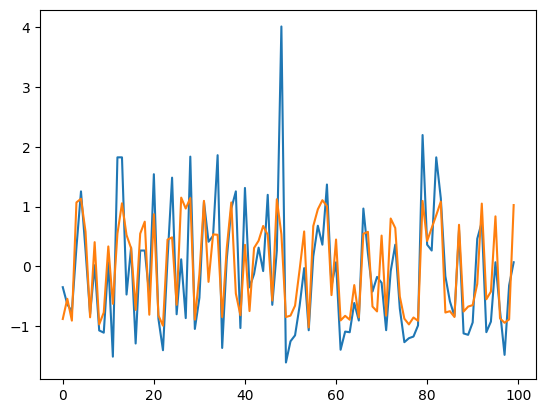

In [50]:
n = 100
plt.plot(train_results['Actuals'][:n])
plt.plot(train_results['Train Predictions'][:n])

In [34]:
# Evaluate the model on training, validation, and test datasets
train_loss, train_rmse = model1.evaluate(X_train, y_train, verbose=0)
val_loss, val_rmse = model1.evaluate(X_val, y_val, verbose=0)
test_loss, test_rmse = model1.evaluate(X_test, y_test, verbose=0)

print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)
print("Test Loss:", test_loss)
print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)

Training Loss: 0.520056962966919
Validation Loss: 0.5057631134986877
Test Loss: 0.4909476935863495
Training RMSE: 0.721149742603302
Validation RMSE: 0.7111702561378479
Test RMSE: 0.7006766200065613


Creating predicted data frames

In [41]:
cities = {
    "233401": (24.68122, 46.62074),
    "65623": (22.316, 39.092),
    "8688": (26.276861, 50.147232),
    "7673": (21.543486, 39.172989),
    "69675": (21.41645, 39.221752),
    "6993": (26.304855, 50.154302),
    "370092": (24.702744, 46.71336),
}
Time_Steps = 12

def CreatingTemplate(time_start, time_end, cities, Time_Steps):
    dates = pd.date_range(start=time_start, end=time_end, freq='h')

    # Creating dataframe
    data = []
    for city, coords in cities.items():
        for date in dates:
            data.append({
                "location_id": city,
                "datetime": date,
                "lat": coords[0],
                "lon": coords[1]
            })

    df = pd.DataFrame(data)

    # Creating day/year sin, cos
    timestamp_s = df['datetime'].map(pd.Timestamp.timestamp)
    day = 60 * 60 * 24
    year = (365.2425) * day
    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    df = df.drop(columns=['datetime'])

    df = pd.get_dummies(df, columns=['location_id'], prefix='loc')
    for column in df.columns:  # Convert binary columns to numerical representation
        if df[column].dtype == 'bool':
            df[column] = df[column].astype(int)

    # Scaling the necessary features
    scaler = StandardScaler()
    df[['lat']] = scaler_lat.fit_transform(df[['lat']])
    df[['lon']] = scaler_lon.fit_transform(df[['lon']])

    def create_sequences(df, Time_Steps):
        output = []
        for i in range(len(df) - Time_Steps):
            output.append(df.iloc[i:(i + Time_Steps)].values)
        return np.array(output)

    X_pred = create_sequences(df, Time_Steps)

    return X_pred

# Example usage:
time_start = '2024-01-01'
time_end = '2024-12-31 23:00:00'

X_pred = CreatingTemplate(time_start, time_end, cities, Time_Steps)

In [42]:
predictions = model1.predict(X_pred)
predictions_rescaled = scaler_aqi.inverse_transform(predictions)

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


In [43]:
data = []
dates = pd.date_range(start=time_start, end=time_end, freq='h')
for city, coords in cities.items():
    for date in dates:
        data.append({
            "location_id": city,
            "datetime": date,
            "lat": coords[0],
            "lon": coords[1]
        })

df = pd.DataFrame(data)
df

,location_id,datetime,lat,lon
0,233401,2024-01-01 00:00:00,24.681220,46.62074
1,233401,2024-01-01 01:00:00,24.681220,46.62074
2,233401,2024-01-01 02:00:00,24.681220,46.62074
3,233401,2024-01-01 03:00:00,24.681220,46.62074
4,233401,2024-01-01 04:00:00,24.681220,46.62074
...,...,...,...,...
61483,370092,2024-12-31 19:00:00,24.702744,46.71336
61484,370092,2024-12-31 20:00:00,24.702744,46.71336
61485,370092,2024-12-31 21:00:00,24.702744,46.71336
61486,370092,2024-12-31 22:00:00,24.702744,46.71336


In [44]:
extended_predictions = []
for prediction in predictions_rescaled:
    extended_predictions.extend([prediction] * Time_Steps)
    
final_predictions = [pred[0] if isinstance(pred, np.ndarray) else pred for pred in extended_predictions[:len(df)]]

df['mean_aqi'] = final_predictions

df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

df['hour'] = df['datetime'].dt.hour
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

df.set_index('datetime', inplace=True)

df

,location_id,lat,lon,mean_aqi,hour,year,month,day
datetime,,,,,,,,
2024-01-01 00:00:00+00:00,233401,24.681220,46.62074,58.173416,0,2024,1,1
2024-01-01 01:00:00+00:00,233401,24.681220,46.62074,58.173416,1,2024,1,1
2024-01-01 02:00:00+00:00,233401,24.681220,46.62074,58.173416,2,2024,1,1
2024-01-01 03:00:00+00:00,233401,24.681220,46.62074,58.173416,3,2024,1,1
2024-01-01 04:00:00+00:00,233401,24.681220,46.62074,58.173416,4,2024,1,1
...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00+00:00,370092,24.702744,46.71336,34.241905,19,2024,12,31
2024-12-31 20:00:00+00:00,370092,24.702744,46.71336,34.241905,20,2024,12,31
2024-12-31 21:00:00+00:00,370092,24.702744,46.71336,34.241905,21,2024,12,31


In [45]:
# Aggregate to compute monthly mean AQI
monthly_aqi = df.groupby(['location_id', 'lat', 'lon', 'year', 'month']).agg({
    'mean_aqi': 'mean'
}).reset_index()

monthly_aqi

,location_id,lat,lon,year,month,mean_aqi
0,233401,24.681220,46.620740,2024,1,54.865204
1,233401,24.681220,46.620740,2024,2,55.570538
2,233401,24.681220,46.620740,2024,3,53.309643
3,233401,24.681220,46.620740,2024,4,53.929382
4,233401,24.681220,46.620740,2024,5,51.700317
...,...,...,...,...,...,...
79,8688,26.276861,50.147232,2024,8,38.112698
80,8688,26.276861,50.147232,2024,9,38.168301
81,8688,26.276861,50.147232,2024,10,37.606964
82,8688,26.276861,50.147232,2024,11,37.981430


In [46]:
# monthly_aqi.to_csv('C:\\Users\\JawadLaptop\\Desktop\\new.csv')